In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp, odeint
from scipy.optimize import curve_fit

# Data loading

In [2]:
breast = pd.read_csv('data/breast_vol_data.txt', sep="\t")
breast.head()

,ID,Time,Observation
0,0,22.0,621.290
1,0,24.0,768.350
2,0,27.0,1132.300
3,0,28.0,1239.755
4,0,32.0,1387.200


In [3]:
lung = pd.read_csv('data/lung_vol_data.txt', sep="\t")

Text(0, 0.5, 'Volume')

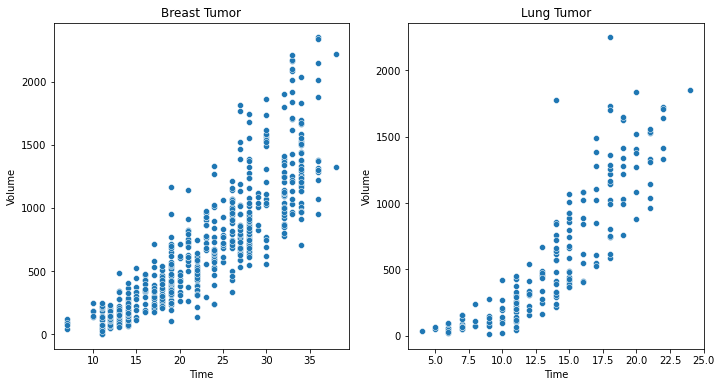

In [4]:
plt.figure(figsize=(18, 6))
plt.subplot(1,3,1)
sns.scatterplot(data=breast, x='Time', y='Observation').set_title('Breast Tumor')
plt.ylabel("Volume")

plt.subplot(1,3,2)
sns.scatterplot(data=lung, x='Time', y='Observation').set_title('Lung Tumor')
plt.ylabel("Volume")

In [5]:
# uncomment the data set you want to run
dat = breast; name = 'Breast Tumor'
# dat = lung; name = 'Lung Tumor'

In [6]:
np.sort(dat['Time'].unique())

array([ 7., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21.,
       22., 23., 24., 25., 26., 27., 28., 29., 30., 32., 33., 34., 36.,
       38.])

In [7]:
dat = dat.groupby('Time').mean()
dat = dat.reset_index()
dat = dat[['Time', 'Observation']]

In [8]:
whole_dat = dat

In [66]:
# frac = 1/4
# frac = 1/2
frac = 3/4
dat = dat[dat.index < (len(dat) * frac)]

# Model definition

In [9]:
def logistic_sol(t, a, b):
    v = b*np.exp(a*t) / (b + np.exp(a*t) - 1)
    return v

In [10]:
def gen_logistic_sol(t, a, b, c):
    v = a / np.power((1 + (np.power(a, b) - 1) * np.exp(-c*b*t)), 1/b)
    return v

In [11]:
def gompertz_sol(t, a, b):
    v = np.exp(a/b * (1-np.exp(-b*t)))
    return v

In [12]:
def bertalanffy_sol(t, a, b):
    v = np.power(a/b + (1-a/b)*np.exp(-b/3*t), 3)
    return v

# Model fitting

In [13]:
t = np.linspace(0, max(whole_dat['Time']) + 1)
# t = whole_dat['Time'] # when calculate ssr

In [14]:
logi_fit = curve_fit(logistic_sol, dat['Time'], dat['Observation'])
logi = logistic_sol(t, logi_fit[0][0], logi_fit[0][1])

In [15]:
logi_fit

(array([3.02477097e-01, 1.47927871e+03]),
 array([[ 6.08155248e-05, -3.86491859e-01],
        [-3.86491859e-01,  6.94862296e+03]]))

In [16]:
gen_logi_fit = curve_fit(gen_logistic_sol, dat['Time'], dat['Observation'], maxfev=100000000)
gen_logi = gen_logistic_sol(t, gen_logi_fit[0][0], gen_logi_fit[0][1], gen_logi_fit[0][2])

In [17]:
gen_logi_fit

(array([2.60779550e+03, 1.57871307e-04, 4.80735566e+02]),
 array([[ 1.54865910e+05, -1.89968843e+01,  5.78188067e+07],
        [-1.89968843e+01,  3.56216856e-03, -1.08426799e+04],
        [ 5.78188067e+07, -1.08426799e+04,  3.30034099e+10]]))

In [18]:
gomp_fit = curve_fit(gompertz_sol, dat['Time'], dat['Observation'], maxfev=100000000)
gomp = gompertz_sol(t, gomp_fit[0][0], gomp_fit[0][1])

/Users/yuqiliu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
gomp_fit

(array([0.59679927, 0.07586581]),
 array([[3.80028968e-04, 6.35744973e-05],
        [6.35744973e-05, 1.07257429e-05]]))

In [20]:
berta_fit = curve_fit(bertalanffy_sol, dat['Time'], dat['Observation'])
berta = bertalanffy_sol(t, berta_fit[0][0], berta_fit[0][1])

In [21]:
berta_fit

(array([1.31271344, 0.06051089]),
 array([[4.43247144e-03, 6.37235615e-04],
        [6.37235615e-04, 9.33282973e-05]]))

Text(0.5, 1.0, 'First 27 time points')

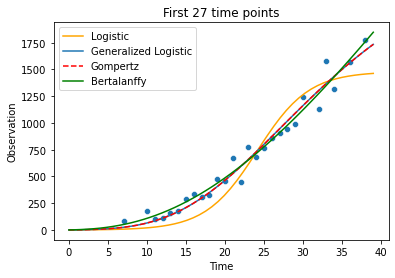

In [22]:
sns.scatterplot(data=whole_dat, x='Time', y='Observation')
plt.plot(t, logi, color='orange', label='Logistic')
plt.plot(t, gen_logi, label='Generalized Logistic')
plt.plot(t, gomp, '--r', label='Gompertz')
plt.plot(t, berta, 'g', label='Bertalanffy')
plt.legend(loc="upper left")
plt.title('First '+str(len(dat))+' time points')

Text(0.5, 0.98, 'Breast Tumor')

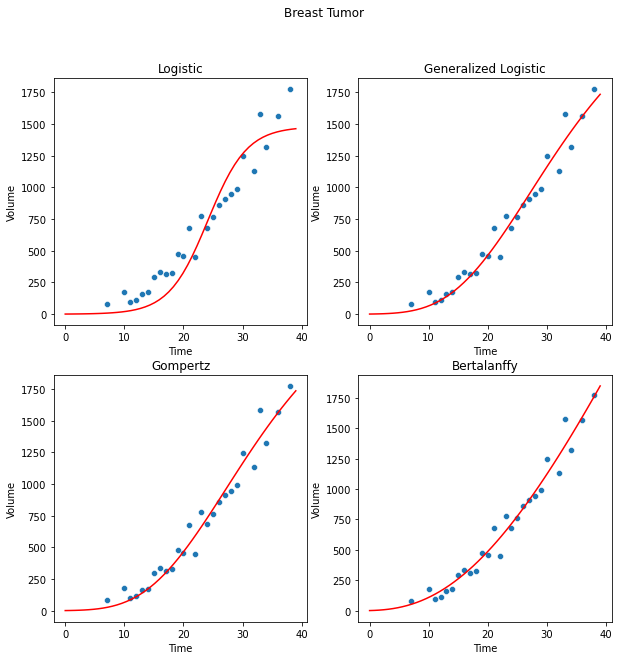

In [23]:
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
sns.scatterplot(data=whole_dat, x='Time', y='Observation').set_title('Logistic')
plt.ylabel("Volume")
plt.plot(t, logi, 'r')

plt.subplot(2,2,2)
sns.scatterplot(data=whole_dat, x='Time', y='Observation').set_title('Generalized Logistic')
plt.ylabel("Volume")
plt.plot(t, gen_logi, 'r')

plt.subplot(2,2,3)
sns.scatterplot(data=whole_dat, x='Time', y='Observation').set_title('Gompertz')
plt.ylabel("Volume")
plt.plot(t, gomp, 'r')

plt.subplot(2,2,4)
sns.scatterplot(data=whole_dat, x='Time', y='Observation').set_title('Bertalanffy')
plt.ylabel("Volume")
plt.plot(t, berta, 'r')

plt.suptitle(name)

# SSR

In [80]:
logi_ssr = sum((whole_dat['Observation'] - logi)**2)

In [81]:
logi_ssr

516275.18748461944

In [82]:
gen_logi_ssr = sum((whole_dat['Observation'] - gen_logi)**2)

In [83]:
gen_logi_ssr

613860.6086178578

In [84]:
gomp_ssr = sum((whole_dat['Observation'] - gomp)**2)

In [85]:
gomp_ssr

615228.4707178089

In [86]:
berta_ssr = sum((whole_dat['Observation'] - berta)**2)

In [87]:
berta_ssr

2617055.125046279

# AIC

In [30]:
def AIC(ssr, n, k):
    aic = n*np.log(ssr/n) + 2*(k+1)*n/(n-k-2)
    return aic

In [31]:
logi_aic = AIC(logi_ssr, 27, 2)

In [32]:
logi_aic

243.83179235009226

In [33]:
gen_logi_aic = AIC(gen_logi_ssr, 27, 3)

In [34]:
gen_logi_aic

212.45595865372525

In [35]:
gomp_aic = AIC(gomp_ssr, 27, 2)

In [36]:
gomp_aic

212.58228313930468

In [37]:
berta_aic = AIC(berta_ssr, 27, 2)

In [38]:
berta_aic

229.81411301157772

# Carrying capacity

In [24]:
logi_k = logi_fit[0][1]

In [25]:
logi_k

1479.2787146121932

In [34]:
gen_logi_k = gen_logi_fit[0][0]

In [35]:
gen_logi_k

2607.795496346666

In [28]:
gomp_k = np.exp(gomp_fit[0][0]/gomp_fit[0][1])

In [29]:
gomp_k

2608.450257418056

In [30]:
berta_k = np.power(berta_fit[0][0]/berta_fit[0][1], 3)

In [31]:
berta_k

10209.611147466649

In [37]:
capacity = pd.Series([logi_k, gen_logi_k, gomp_k, berta_k])

In [38]:
name = pd.Series(['logistic', 'generalized logistic', 'gompertz', 'bertalanffy'])

In [39]:
k = pd.concat([capacity, name], axis=1, ignore_index=True)

In [40]:
k.columns=['volume', 'model']

Text(0.5, 1.0, 'Carrying Capacity')

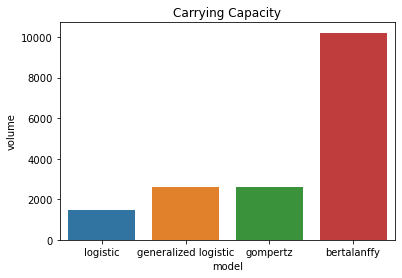

In [41]:
sns.barplot(x='model', y='volume', data=k).set_title('Carrying Capacity')

# Chemotherapy

In [56]:
logi_c = logi_fit[0][0] - logi_fit[0][0] / logi_fit[0][1]

In [57]:
logi_c

0.3022726205482599

In [58]:
gen_logi_c = gen_logi_fit[0][2] * (1 - np.power(1/gen_logi_fit[0][0], gen_logi_fit[0][1]))

In [59]:
gen_logi_c

0.5966342023678374

In [60]:
gomp_c = gomp_fit[0][0]

In [61]:
gomp_c

0.5967992704617556

In [62]:
berta_c = berta_fit[0][0] - berta_fit[0][1]

In [63]:
berta_c

1.2522025484953545

In [64]:
chem = pd.Series([logi_c, gen_logi_c, gomp_c, berta_c])

In [65]:
name = pd.Series(['logistic', 'generalized logistic', 'gompertz', 'bertalanffy'])

In [66]:
c = pd.concat([chem, name], axis=1, ignore_index=True)

In [67]:
c.columns=['chemotherapy', 'model']

Text(0.5, 1.0, 'Chemotherapy')

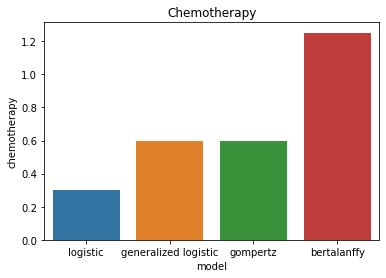

In [68]:
sns.barplot(x='model', y='chemotherapy', data=c).set_title('Chemotherapy')